In [1]:
%load_ext autoreload
%autoreload 2

import geoopt
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from geoopt.manifolds.lorentz import Lorentz
from geoopt.manifolds.lorentz import math

from torch.utils.data import TensorDataset, DataLoader

In [12]:
def sample_params(dim, zero=False):
    # Generate model parameters
    p = torch.randn((1, dim)) * 2.0
    if zero:
        p /= 1000
    p = man.projx(p) # project onto the hyperboloid 
    man._check_point_on_manifold(p[0])
    orig = man.origin((1, dim))
    beta = torch.randn((1, dim)) * 2.0
    if zero:
        beta /= 1000
    beta /= beta.norm(dim=-1)
    beta = man.proju(orig, beta)
    beta = man.transp(orig, p, beta)
    return p, beta

def plot_params(p, beta):
    p_np = p.numpy()
    beta_np = beta.numpy()
    lins_x = np.linspace(-3, 3, 100)
    linx_y = np.sqrt(k + lins_x**2)
    plt.plot(lins_x, linx_y, color="C1", label="Hyperboloid")
    plt.scatter(p_np[:, 1], p_np[:, 0], label="intercept p")
    plt.arrow(p_np[0, 1], p_np[0, 0], beta_np[0, 1], beta_np[0, 0], 
        width=0.01, color="C2", label="weight beta")
    plt.legend()

def add_noise(y, dim, sig=1.0):
    n = y.shape[0]
    orig = man.origin((1, dim))
    eps = torch.randn(n, dim) * sig
    eps = man.proju(orig, eps)
    eps = man.transp(orig, y, eps)
    ynoise = man.expmap(y, eps)
    return ynoise

def generate_data(n, p, beta, dim):
    x = (torch.rand(n, 1) * 10.0) - 5.0
    y = man.expmap(p, x * beta)
    ynoise = add_noise(y, dim, sig=1.0)
    return x, ynoise, y

k = 50 # choose curvature parameter
d = 80
dim = d + 1
man = Lorentz(k=k)
n_train = 100 # 1000
n_test = 100 # 500
n = n_train + n_test
p, beta = sample_params(dim)
x, y, y_true = generate_data(n, p, beta, dim)

if d == 1:
    plot_params(p, beta)
    plt.scatter(y[:, 1], y[:, 0], alpha=0.1, color='C3', label='data')
    plt.show()


In [13]:
class GeodesicRegressor():
    def __init__(self, K, dim, man):
        self.K = K
        self.dim = dim
        self.man = man
        q, alpha = sample_params(dim, zero=True)
        self.q = torch.autograd.Variable(q, requires_grad=True)
        self.alpha = torch.autograd.Variable(alpha, requires_grad=True)

    def fit(self, X, Y, epochs=300, lr=0.01, verbose=False):
        n = X.shape[0]

        dataset = TensorDataset(X, Y)
        dataloader = DataLoader(dataset, batch_size=n)
        for e in range(epochs):
            for X, Y in dataloader:
                
                Y_hat = self.man.expmap(self.q, X * self.alpha)
                loss = torch.mean(self.man.dist2(Y, Y_hat))
                #print(f"Loss: {loss.item()}")
                
                # Optimization step
                loss.backward()
                with torch.no_grad():

                    # Get riemannian gradient 
                    dq = self.man.egrad2rgrad(self.q, self.q.grad)
                    qnew = self.man.expmap(self.q, -lr * dq)
                    # Gradient of alpha should be in the tangent space of q
                    dalpha = self.man.egrad2rgrad(self.q, self.alpha.grad)
                    alphanew = self.alpha - (lr * dalpha)
                    alphanew = self.man.transp(self.q, qnew, alphanew)

                    self.alpha.zero_()
                    self.alpha.add_(alphanew)
                    self.q.zero_()
                    self.q.add_(qnew)

                self.alpha.grad.zero_()
                self.q.grad.zero_()

            dataset = TensorDataset(X, Y)
            dataloader = DataLoader(dataset, batch_size=n)
            losses = []
            for X, Y in dataloader:
                with torch.no_grad():
                    Y_hat = self.man.expmap(self.q, X * self.alpha)
                    loss = torch.mean(self.man.dist2(Y, Y_hat))
            losses.append(loss.detach().numpy())

        return losses[-1]

    def predict(self, X):
        Y_hat = man.expmap(self.q, X * self.alpha)
        return Y_hat

model = GeodesicRegressor(k, dim, man)
train_loss =  model.fit(x[:n_train], y[:n_train])
yhat = model.predict(x[n_train:])
val_loss = torch.mean(man.dist2(y[n_train:], yhat))
print(f'Training loss: {train_loss:.4}')
print(f"Validation loss:{val_loss:.4}")

if d == 1:
    plot_params(
        model.q.detach(), 
        model.alpha.detach())

Training loss: 79.81
Validation loss:80.24


10 examples... Validation loss:95.8736343383789
20 examples... Validation loss:86.83772277832031
30 examples... Validation loss:83.52291107177734
40 examples... Validation loss:82.27775573730469
50 examples... Validation loss:81.63468933105469
60 examples... Validation loss:81.14434814453125
70 examples... Validation loss:80.92344665527344
80 examples... Validation loss:80.72591400146484
90 examples... Validation loss:80.50428009033203
100 examples... Validation loss:80.23255157470703


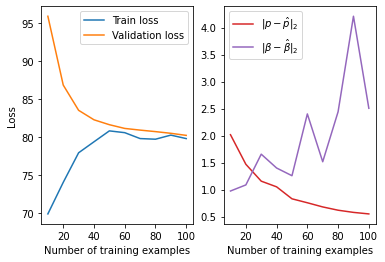

In [14]:
subset_sizes = range(10, n_train+1, 10)
train_losses = []
val_losses = []
pq_norms = []
ba_norms = []

for n_subset in subset_sizes:
    model = GeodesicRegressor(k, dim, man)
    train_loss = model.fit(x[:n_subset], y[:n_subset])
    train_losses.append(train_loss)

    pq_norms.append(
        np.linalg.norm(p[0] - model.q.detach().numpy()[0], ord=2))
    ba_norms.append(
        np.linalg.norm(beta[0] - model.alpha.detach().numpy()[0], ord=2))

    yhat = model.predict(x[n_train:])
    val_loss = torch.mean(man.dist2(y[n_train:], yhat))
    val_losses.append(val_loss.detach().numpy())
    print(f"{n_subset} examples... Validation loss:{val_loss}")


fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(subset_sizes, train_losses, label='Train loss')
ax[0].plot(subset_sizes, val_losses, label='Validation loss')
ax[0].set_xlabel('Number of training examples')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(subset_sizes, pq_norms, color='C3', 
    label=r'$\|p - \hat{p}\|_2$')
ax[1].plot(subset_sizes, ba_norms, color='C4', 
    label=r'$\|\beta - \hat{\beta}\|_2$')
ax[1].set_xlabel('Number of training examples')
ax[1].legend()

plt.show()

# Generate LFs

In [111]:
class LFGenerator():
    def __init__(self, num_lfs, siglb=2, sigub=5, heterogeneous=True):
        self.siglb = siglb
        self.sigub = sigub
        self.heterogeneous = heterogeneous
        self.num_lfs = num_lfs
        self.sigs = []

    def fit(self, sep=15):
        for i in range(self.num_lfs):
            coin = np.random.randint(0, 2) * self.heterogeneous
            sig = np.random.uniform(
                self.siglb + (coin*sep), self.sigub + (coin*sep))
            self.sigs.append(sig)
    
    def predict(self, Y_true):
        lambdas = []
        for i in range(self.num_lfs):
            lambda_i_preds = add_noise(Y_true, dim, sig=self.sigs[i])
            lambdas.append(lambda_i_preds)
        return lambdas

In [112]:
from tqdm import tqdm

class GeodesicLabelModel():
    def __init__(self, num_triplets=1):
        self.num_triplets = num_triplets
        self.num_lfs = self.num_triplets * 3
        self.thetas = []

    def fit(self, lambdas):
        dim = lambdas[0].shape[1]
        for i in range(self.num_triplets):
            Eab = torch.mean(
                man.dist(lambdas[(i*3)+0], lambdas[(i*3)+1])) / dim
            Ebc = torch.mean(
                man.dist(lambdas[(i*3)+1], lambdas[(i*3)+2])) / dim
            Eac = torch.mean(
                man.dist(lambdas[(i*3)+0], lambdas[(i*3)+2])) / dim
            E = np.array([Eab, Ebc, Eac])
            coef = np.array([[1, 1, 0], [0, 1, 1], [1, 0, 1]])
            thetas_abc = np.reciprocal(np.linalg.solve(coef, E))
            self.thetas += list(thetas_abc)
        #if average:
        #    self.thetas = [np.mean(self.thetas)] * self.num_lfs

    def predict(self, lambdas, max_steps=200, lr=0.001, 
            verbose=False, vote=False):
        n = lambdas[0].shape[0]
        ys = torch.zeros_like(lambdas[0])
        for i in tqdm(range(n)):
            if vote:
                thetas = np.ones_like(self.thetas)
            else:
                thetas = self.thetas
            # Initialize y to be on the manifold
            y = torch.randn_like(lambdas[0][0])
            y = torch.autograd.Variable(man.projx(y), requires_grad=True) 
            
            for step in range(max_steps):
                objective = torch.zeros(1)
                for j in range(self.num_lfs):
                    objective += (
                        thetas[j] * man.dist2(lambdas[j][i], y))
                objective.backward()

                # Riemannian descent step
                with torch.no_grad():
                    dy = man.egrad2rgrad(y, y.grad)
                    ynew = man.expmap(y, -lr * dy)
                    y.zero_()
                    y.add_(ynew)
                y.grad.zero_()
            
                if verbose:
                    print(i, step, objective.item())
            
            ys[i] += y
        return ys


In [113]:
num_lambdas = 3
lfGenerator = LFGenerator(num_lambdas, siglb=1.5, sigub=2.0) # TODO
lfGenerator.fit()
lambdas = lfGenerator.predict(y_true)

In [114]:
labelModel = GeodesicLabelModel(num_triplets=num_lambdas//3)
lambdas_train = [lambdas[i][:n_train, :] for i in range(len(lambdas))]
labelModel.fit(lambdas_train) # TODO only fit label model with train examples? 
weak_labels = labelModel.predict(lambdas, max_steps=50, verbose=False)

100%|██████████| 200/200 [00:05<00:00, 36.24it/s]


In [115]:
def get_clean_loss(n_clean):
    #n_clean = n_train // 4
    model = GeodesicRegressor(k, dim, man)
    train_loss = model.fit(x[:n_clean], y[:n_clean])
    yhat = model.predict(x[n_train:])
    val_loss = torch.mean(man.dist2(y[n_train:], yhat))
    val_loss = val_loss.detach().numpy()
    print(f"Validation loss clean: {val_loss}")
    return val_loss

def get_ws_loss(n_clean, weak_labels):
    weak_labels = torch.Tensor(weak_labels.detach().numpy())
    model = GeodesicRegressor(k, dim, man)
    extended_labels = torch.vstack(
        [y[:n_clean], weak_labels[n_clean:n_train]])
    train_loss = model.fit(x[:n_train], extended_labels)
    yhat = model.predict(x[n_train:])
    val_loss = torch.mean(man.dist2(y[n_train:], yhat))
    val_loss = val_loss.detach().numpy()
    print(f"Validation loss weakly supervised: {val_loss}")
    return val_loss

def get_ws_loss_lambdas(n_clean, num_lambdas, 
        siglb=1.5, sigub=2.0, vote=False, max_steps=100):
    lfGenerator = LFGenerator(num_lambdas, siglb=siglb, sigub=sigub)
    lfGenerator.fit()
    lambdas = lfGenerator.predict(y_true) # TODO y or y_true ? 
    # TODO only need weak labels for train set
    lambdas_train = [lambdas[i][:n_train, :] for i in range(len(lambdas))]
    if vote:
        labelModel = GeodesicLabelModel(num_triplets=num_lambdas//3)
        labelModel.fit(lambdas_train) 
        # TODO only fit label model with train examples? 
        weak_labels = labelModel.predict(lambdas_train, max_steps=max_steps, verbose=False, vote=False)
        ws_loss = get_ws_loss(n_clean, weak_labels)

        # TODO only fit label model with train examples? 
        weak_labels = labelModel.predict(lambdas_train, max_steps=max_steps, verbose=False, vote=True)
        vote_loss = get_ws_loss(n_clean, weak_labels)

        return ws_loss, labelModel, vote_loss
    else:
        labelModel = GeodesicLabelModel(num_triplets=num_lambdas//3)
        labelModel.fit(lambdas_train) 
        # TODO only fit label model with train examples? 
        weak_labels = labelModel.predict(lambdas_train, max_steps=max_steps, verbose=False, vote=False)
        return get_ws_loss(n_clean, weak_labels), labelModel

In [116]:
get_clean_loss(n_train // 2)
get_ws_loss(n_train // 2, weak_labels)

Validation loss clean: 81.6328353881836
Validation loss weakly supervised: 80.50736999511719


array(80.50737, dtype=float32)

In [117]:
fracs = [80, 90, n_train] 
#range(100, n_train+1, 200)

clean_losses = []
for i in range(len(fracs)):
    loss = get_clean_loss(fracs[i])
    clean_losses.append(loss)
    

Validation loss clean: 80.73615264892578
Validation loss clean: 80.51275634765625
Validation loss clean: 80.23872375488281


In [118]:
num_lfs = [3, 6, 9, 12, 15, 18, 21]
ws_losses = []
vote_losses = []
label_models = []

siglb = 1.5

for num_lf in num_lfs:
    #ws_loss, _ = get_ws_loss_lambdas(0, num_lf)
    #ws_losses.append(ws_loss)

    ws_loss, label_model, vote_loss = get_ws_loss_lambdas(0, num_lf, 
        siglb=siglb, sigub=siglb+4.0, vote=True, max_steps=100)
    ws_losses.append(ws_loss)
    label_models.append(label_model)
    vote_losses.append(vote_loss)

  2%|▏         | 2/100 [00:00<00:05, 18.50it/s]

Validation loss weakly supervised: 79.9080810546875


  2%|▏         | 2/100 [00:00<00:09, 10.59it/s]

Validation loss weakly supervised: 79.93964385986328


  2%|▏         | 2/100 [00:00<00:09, 10.58it/s]

Validation loss weakly supervised: 79.7348403930664


  1%|          | 1/100 [00:00<00:13,  7.40it/s]

Validation loss weakly supervised: 79.88412475585938


  1%|          | 1/100 [00:00<00:13,  7.26it/s]

Validation loss weakly supervised: 79.64030456542969


  1%|          | 1/100 [00:00<00:18,  5.43it/s]

Validation loss weakly supervised: 79.7498779296875


  1%|          | 1/100 [00:00<00:18,  5.45it/s]

Validation loss weakly supervised: 79.54501342773438


  0%|          | 0/100 [00:00<?, ?it/s]

Validation loss weakly supervised: 79.66477966308594


  0%|          | 0/100 [00:00<?, ?it/s]

Validation loss weakly supervised: 79.56062316894531


  0%|          | 0/100 [00:00<?, ?it/s]

Validation loss weakly supervised: 79.58931732177734


  0%|          | 0/100 [00:00<?, ?it/s]

Validation loss weakly supervised: 79.55292510986328


  0%|          | 0/100 [00:00<?, ?it/s]

Validation loss weakly supervised: 79.61567687988281


  0%|          | 0/100 [00:00<?, ?it/s]

Validation loss weakly supervised: 79.51762390136719


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Validation loss weakly supervised: 79.57785034179688


[80, 90, 100]
[array(80.73615, dtype=float32), array(80.51276, dtype=float32), array(80.23872, dtype=float32)]
[3, 6, 9, 12, 15, 18, 21]
[array(79.90808, dtype=float32), array(79.73484, dtype=float32), array(79.640305, dtype=float32), array(79.54501, dtype=float32), array(79.56062, dtype=float32), array(79.552925, dtype=float32), array(79.517624, dtype=float32)]
[array(79.939644, dtype=float32), array(79.884125, dtype=float32), array(79.74988, dtype=float32), array(79.66478, dtype=float32), array(79.58932, dtype=float32), array(79.61568, dtype=float32), array(79.57785, dtype=float32)]


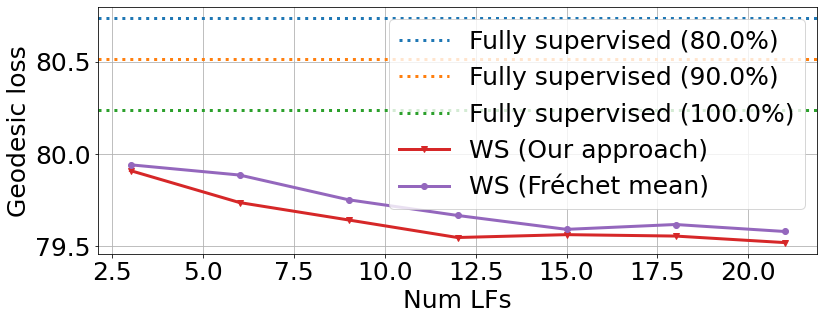

In [122]:
plt.rcParams['font.size'] = '25'
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

for i in range(len(fracs)):
    ax.axhline(clean_losses[i], linestyle=':', color=f'C{i}', linewidth=3,  
        label=f'Fully supervised ({(fracs[i]/n_train)*100}%)')

ax.plot(num_lfs, ws_losses, '-v', label='WS (Our approach)',
    linewidth=3, color='C3')
ax.plot(num_lfs, vote_losses, '-o', label='WS (Fréchet mean)',
    linewidth=3, color='C4')

print(fracs)
print(clean_losses)
print(num_lfs)
print(ws_losses)
print(vote_losses)


ax.set_ylabel('Geodesic loss')
ax.set_xlabel('Num LFs')
#ax.yscale('log')
ax.grid()
ax.legend()
plt.tight_layout()
plt.savefig('geodesic_numLFs.pdf')
plt.show()

# average theta exps

In [84]:
siglbs = [1.5, 14.0]#3.0, 6.0, 12.0]
num_lf = 9
ws_losses = []
label_models = []

vote_losses = []
for siglb in siglbs:
    # Label model and vote
    ws_loss, label_model, vote_loss = get_ws_loss_lambdas(0, num_lf, 
        siglb=siglb, sigub=siglb+4.0, vote=True, max_steps=100)
    ws_losses.append(ws_loss)
    label_models.append(label_model)
    vote_losses.append(vote_loss)

  1%|          | 1/100 [00:00<00:13,  7.22it/s]

Validation loss weakly supervised: 79.64262390136719


  1%|          | 1/100 [00:00<00:14,  6.95it/s]

Validation loss weakly supervised: 79.59660339355469


  1%|          | 1/100 [00:00<00:14,  6.95it/s]

Validation loss weakly supervised: nan


100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Validation loss weakly supervised: nan


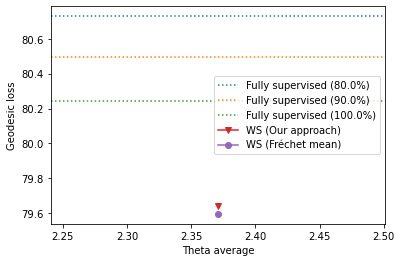

In [85]:
for i in range(len(fracs)):
    plt.axhline(clean_losses[i], linestyle=':', color=f'C{i}', 
        label=f'Fully supervised ({(fracs[i]/n_train)*100}%)')

theta_averages = [np.mean(lm.thetas) for lm in label_models]
plt.plot(theta_averages[:], ws_losses[:], '-v', label='WS (Our approach)', 
    color='C3')
plt.plot(theta_averages[:], vote_losses[:], '-o', label='WS (Fréchet mean)', 
    color='C4')

plt.ylabel('Geodesic loss')
plt.xlabel('Theta average')
#plt.yscale('log')
plt.legend()
plt.savefig('geodesic-theta.pdf')
plt.show()